In [ ]:
import os

# Clear output
from IPython.display import clear_output
clear_output()

# Reset variables (this might not be completely exhaustive)
%reset -f


In [ ]:
!pip install scikit-learn

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
try:
  df = pd.read_csv('/content/Taxi_2023-03-19.csv')
  print("File read successfully.")
except FileNotFoundError:
  print(f"File not found at: {file_path}")
except Exception as e:
  print(f"An error occurred while reading the file: {e}")


<ipython-input-4-2eb11d94351c>:2: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/Taxi_2023-03-19.csv')


File read successfully.


In [ ]:
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1871999 entries, 0 to 1871998
Data columns (total 17 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Unnamed: 0                int64  
 1   Record.Group.Entry        float64
 2   Record.Group.Exit         float64
 3   Entry.time                object 
 4   Exit.time                 object 
 5   Entry.hour                float64
 6   Exit.hour                 float64
 7   Dwell.Time                object 
 8   Time.Since.Previous.Trip  object 
 9   Complete.trip             object 
 10  TripId                    float64
 11  #TaxiMonthlyTrips         int64  
 12  #TaxiMonthlyTripsQuota    int64  
 13  #Trips                    int64  
 14  Vehicle_Anon              object 
 15  Company_Anon              object 
 16  Card_Anon                 object 
dtypes: float64(5), int64(4), object(8)
memory usage: 242.8+ MB


,Unnamed: 0,Record.Group.Entry,Record.Group.Exit,Entry.hour,Exit.hour,TripId,#TaxiMonthlyTrips,#TaxiMonthlyTripsQuota,#Trips
count,1.871999e+06,1.761522e+06,1.538164e+06,1.761522e+06,1.538164e+06,1.871999e+06,1.871999e+06,1871999.0,1.871999e+06
mean,9.360000e+05,2.434046e+06,2.401833e+06,1.457520e+01,1.452091e+01,2.403539e+06,2.246230e+02,45.0,9.356816e-01
std,5.403997e+05,1.482761e+06,1.496768e+06,6.133856e+00,6.218618e+00,1.494334e+06,1.175677e+02,0.0,2.453194e-01
min,1.000000e+00,2.067340e+05,2.067350e+05,0.000000e+00,0.000000e+00,2.067340e+05,1.000000e+00,45.0,0.000000e+00
25%,4.680005e+05,1.075801e+06,1.014899e+06,1.100000e+01,1.100000e+01,1.025545e+06,1.420000e+02,45.0,1.000000e+00
50%,9.360000e+05,2.426368e+06,2.401356e+06,1.500000e+01,1.500000e+01,2.408017e+06,2.110000e+02,45.0,1.000000e+00
75%,1.404000e+06,3.694986e+06,3.660272e+06,2.000000e+01,2.000000e+01,3.661870e+06,2.800000e+02,45.0,1.000000e+00
max,1.871999e+06,5.486324e+06,5.486324e+06,2.300000e+01,2.300000e+01,5.486324e+06,6.570000e+02,45.0,1.000000e+00


In [ ]:
# Step 1: Convert 'Entry.time' to datetime
df['Entry.time'] = pd.to_datetime(df['Entry.time'], errors='coerce')
df['Dwell.Time'] = pd.to_numeric(df['Dwell.Time'], errors='coerce')
# Step 2: Drop rows with missing Entry.time
df_cleaned = df.dropna(subset=['Entry.time']).copy()

# Step 3: Create hourly timestamp
df_cleaned['Entry_Hour'] = df_cleaned['Entry.time'].dt.floor('H')


# Step 4: Convert 'Complete.trip' to binary flag
df_cleaned['Complete_trip_flag'] = df_cleaned['Complete.trip'].map({'Yes': 1, 'No': 0})

# Step 5: Aggregate hourly features
aggregated_features = df_cleaned.groupby('Entry_Hour').agg(
    avg_dwell_time=('Dwell.Time', 'mean'),
    pct_complete_trips=('Complete_trip_flag', 'mean'),
    avg_monthly_trips=('#TaxiMonthlyTrips', 'mean'),
    avg_trips_per_hour=('#Trips', 'mean')
).reset_index()

# Step 6: Count taxi arrivals per hour
hourly_arrivals = df_cleaned.groupby('Entry_Hour').size().reset_index(name='Taxi_Arrivals')

# Step 7: Merge all into one DataFrame
hourly_data = pd.merge(hourly_arrivals, aggregated_features, on='Entry_Hour')

# Step 8 (optional): Sort by time
hourly_data = hourly_data.sort_values(by='Entry_Hour').reset_index(drop=True)

# View result
print(hourly_data.head())

<ipython-input-7-21a933b08a13>:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_cleaned['Entry_Hour'] = df_cleaned['Entry.time'].dt.floor('H')


           Entry_Hour  Taxi_Arrivals  avg_dwell_time  pct_complete_trips  \
0 2018-01-01 00:00:00            141        3.982910                 1.0   
1 2018-01-01 01:00:00            103        2.357700                 1.0   
2 2018-01-01 02:00:00             38        4.247568                 1.0   
3 2018-01-01 03:00:00              9        1.776667                 1.0   
4 2018-01-01 04:00:00             15       28.011333                 1.0   

   avg_monthly_trips  avg_trips_per_hour  
0         248.290780                 1.0  
1         256.951456                 1.0  
2         231.105263                 1.0  
3         225.222222                 1.0  
4         271.600000                 1.0  


In [ ]:
hourly_data.info()
hourly_data = hourly_data.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38941 entries, 0 to 38940
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Entry_Hour          38941 non-null  datetime64[ns]
 1   Taxi_Arrivals       38941 non-null  int64         
 2   avg_dwell_time      37534 non-null  float64       
 3   pct_complete_trips  38941 non-null  float64       
 4   avg_monthly_trips   38941 non-null  float64       
 5   avg_trips_per_hour  38941 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 1.8 MB


In [ ]:
hourly_data.isna().sum()

,0
Entry_Hour,0
Taxi_Arrivals,0
avg_dwell_time,0
pct_complete_trips,0
avg_monthly_trips,0
avg_trips_per_hour,0


In [ ]:
hourly_data['hour'] = hourly_data['Entry_Hour'].dt.hour               # 0–23
hourly_data['day_of_week'] = hourly_data['Entry_Hour'].dt.dayofweek   # 0 = Monday, 6 = Sunday
hourly_data['is_weekend'] = hourly_data['day_of_week'].isin([5, 6]).astype(int)
print(hourly_data.head())

           Entry_Hour  Taxi_Arrivals  avg_dwell_time  pct_complete_trips  \
0 2018-01-01 00:00:00            141        3.982910                 1.0   
1 2018-01-01 01:00:00            103        2.357700                 1.0   
2 2018-01-01 02:00:00             38        4.247568                 1.0   
3 2018-01-01 03:00:00              9        1.776667                 1.0   
4 2018-01-01 04:00:00             15       28.011333                 1.0   

   avg_monthly_trips  avg_trips_per_hour  hour  day_of_week  is_weekend  
0         248.290780                 1.0     0            0           0  
1         256.951456                 1.0     1            0           0  
2         231.105263                 1.0     2            0           0  
3         225.222222                 1.0     3            0           0  
4         271.600000                 1.0     4            0           0  


In [ ]:
hourly_data.head()

,Entry_Hour,Taxi_Arrivals,avg_dwell_time,pct_complete_trips,avg_monthly_trips,avg_trips_per_hour,hour,day_of_week,is_weekend
0,2018-01-01 00:00:00,141,3.982910,1.0,248.290780,1.0,0,0,0
1,2018-01-01 01:00:00,103,2.357700,1.0,256.951456,1.0,1,0,0
2,2018-01-01 02:00:00,38,4.247568,1.0,231.105263,1.0,2,0,0
3,2018-01-01 03:00:00,9,1.776667,1.0,225.222222,1.0,3,0,0
4,2018-01-01 04:00:00,15,28.011333,1.0,271.600000,1.0,4,0,0


In [ ]:
# Sort by time just in case
hourly_data = hourly_data.sort_values(by='Entry_Hour').reset_index(drop=True)

# Define split point (e.g., 80% for training)
split_index = int(len(hourly_data) * 0.8)

# Split the data
train_data = hourly_data.iloc[:split_index]
test_data = hourly_data.iloc[split_index:]

hourly_data.head()

,Entry_Hour,Taxi_Arrivals,avg_dwell_time,pct_complete_trips,avg_monthly_trips,avg_trips_per_hour,hour,day_of_week,is_weekend
0,2018-01-01 00:00:00,141,3.982910,1.0,248.290780,1.0,0,0,0
1,2018-01-01 01:00:00,103,2.357700,1.0,256.951456,1.0,1,0,0
2,2018-01-01 02:00:00,38,4.247568,1.0,231.105263,1.0,2,0,0
3,2018-01-01 03:00:00,9,1.776667,1.0,225.222222,1.0,3,0,0
4,2018-01-01 04:00:00,15,28.011333,1.0,271.600000,1.0,4,0,0


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Features to use for prediction
features = ['hour', 'day_of_week', 'is_weekend', 'avg_dwell_time',
            'pct_complete_trips', 'avg_monthly_trips', 'avg_trips_per_hour']

# Prepare training and test sets
X_train = train_data[features]
y_train = train_data['Taxi_Arrivals']

X_test = test_data[features]
y_test = test_data['Taxi_Arrivals']

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Create a DataFrame to display the predictions
prediction_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Entry_Hour': test_data['Entry_Hour']})

# Display the DataFrame
prediction_df.head(100)


,Actual,Predicted,Entry_Hour
30027,49,76.659089,2022-04-03 20:00:00
30028,52,77.671632,2022-04-03 21:00:00
30029,41,77.751749,2022-04-03 22:00:00
30030,20,63.763094,2022-04-03 23:00:00
30031,23,48.040359,2022-04-04 00:00:00
...,...,...,...
30122,2,-24.194530,2022-04-08 05:00:00
30123,3,-25.224795,2022-04-08 06:00:00
30124,5,31.811478,2022-04-08 07:00:00
30125,22,85.839268,2022-04-08 08:00:00


In [ ]:
# Evaluate the model
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"MAPE: {mape:.2f}%")
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

MAPE: 472.73%
Root Mean Squared Error (RMSE): 65.77


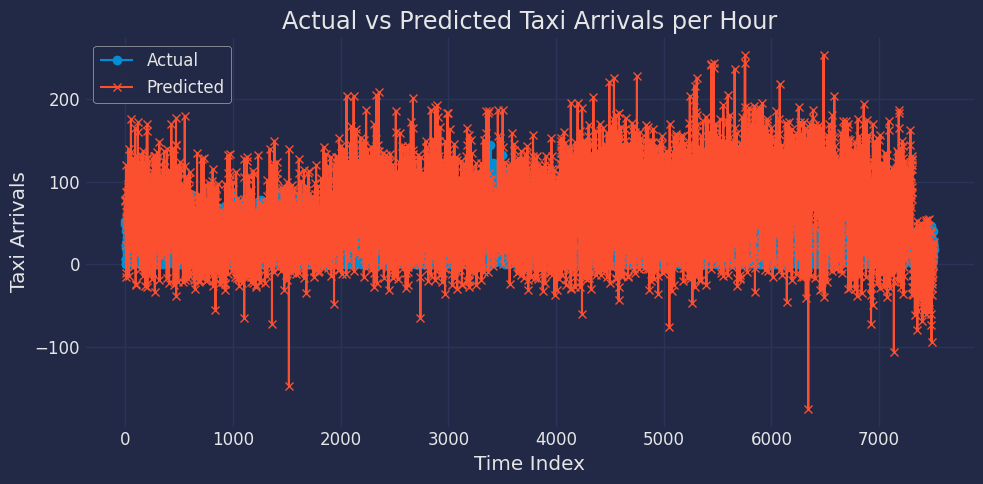

In [ ]:
# Step 11: Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Taxi Arrivals per Hour')
plt.xlabel('Time Index')
plt.ylabel('Taxi Arrivals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# XGboost model



<ipython-input-16-977e5c1b70c5>:9: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/Taxi_2023-03-19.csv')
<ipython-input-16-977e5c1b70c5>:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['Entry_Hour'] = df['Entry.time'].dt.floor('H') # Truncates time to the hour (e.g., 1:43 → 1:00)
<ipython-input-16-977e5c1b70c5>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Entry_Hour'] = df['Entry.time'].dt.floor('H') # Truncates time to the hour (e.g., 1:43 → 1:00)


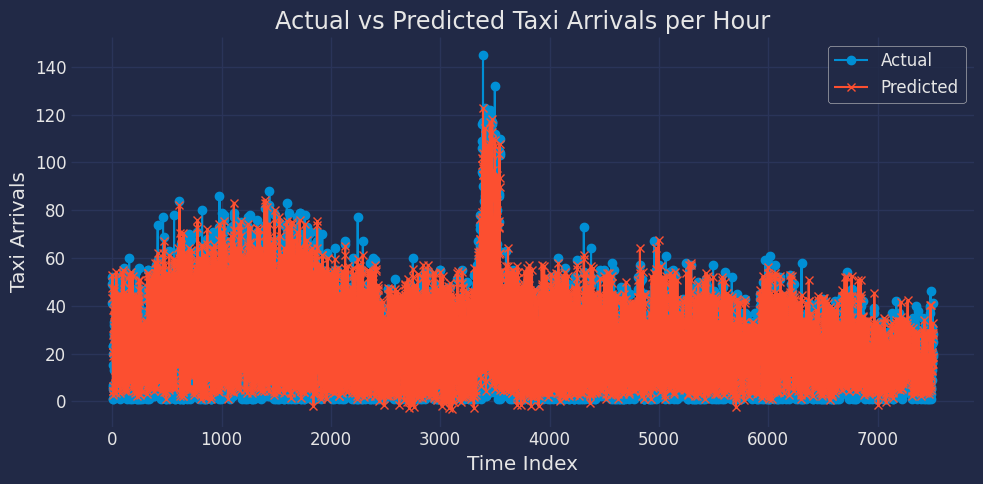

MAPE: 54.42%
Root Mean Squared Error (RMSE): 8.11


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Step 1: Load data

df = pd.read_csv('/content/Taxi_2023-03-19.csv')

# Step 2: Preprocess datetime and numeric fields
df['Entry.time'] = pd.to_datetime(df['Entry.time'], errors='coerce') # change format
df['Dwell.Time'] = pd.to_numeric(df['Dwell.Time'], errors='coerce')
df = df.dropna(subset=['Entry.time']) # drop missing value

# Step 3: Feature engineering
df['Entry_Hour'] = df['Entry.time'].dt.floor('H') # Truncates time to the hour (e.g., 1:43 → 1:00)
df['Hour'] = df['Entry_Hour'].dt.hour # The hour of the day (0–23)
df['Weekday'] = df['Entry_Hour'].dt.dayofweek #Day of the week (0=Monday)
df['Complete_trip_flag'] = df['Complete.trip'].map({'Yes': 1, 'No': 0}) # Converts "Yes"/"No" into 1/0 for analysis

# Step 4: Aggregate hourly features
hourly_features = df.groupby('Entry_Hour').agg(
    Taxi_Arrivals=('Entry_Hour', 'count'),
    avg_dwell_time=('Dwell.Time', 'mean'),
    pct_complete_trips=('Complete_trip_flag', 'mean'),
    avg_monthly_trips=('#TaxiMonthlyTrips', 'mean'),
    avg_trips=('#Trips', 'mean'),
    Hour=('Hour', 'first'),
    Weekday=('Weekday', 'first')
).reset_index()

# Step 5: Create lag and rolling features
hourly_features['lag_1'] = hourly_features['Taxi_Arrivals'].shift(1)
hourly_features['lag_2'] = hourly_features['Taxi_Arrivals'].shift(2)
hourly_features['rolling_3hr'] = hourly_features['Taxi_Arrivals'].rolling(3).mean()

'''
Creates time-aware features:

lag_1: Taxi arrivals one hour ago

lag_2: Two hours ago

rolling_3hr: 3-hour moving average

These help the model understand temporal patterns.
'''

# Step 6: Drop NA values caused by lag/rolling
hourly_features = hourly_features.dropna().reset_index(drop=True)

# Step 7: Define features and target
feature_cols = ['avg_dwell_time', 'pct_complete_trips', 'avg_monthly_trips',
                'avg_trips', 'Hour', 'Weekday', 'lag_1', 'lag_2', 'rolling_3hr']
X = hourly_features[feature_cols]
y = hourly_features['Taxi_Arrivals']

# Step 8: Time-based train/test split (80/20)
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Step 9: Train XGBoost model
model = XGBRegressor(
    n_estimators=50,# number of trees to build
    max_depth=3, # max depth of each tree (how complex it can be)
    objective='reg:squarederror', # loss function for regression
    random_state=42
)
model.fit(X_train, y_train)

# Step 10: Predict and evaluate
y_pred = model.predict(X_test)

# Step 11: Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Taxi Arrivals per Hour')
plt.xlabel('Time Index')
plt.ylabel('Taxi Arrivals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 12: Validation
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"MAPE: {mape:.2f}%")
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

In [ ]:
results_df = pd.DataFrame({
    'Entry_Hour': hourly_features['Entry_Hour'].iloc[split_index:].values,
    'Actual_Taxi_Arrivals': y_test.values,
    'Predicted_Taxi_Arrivals': y_pred.round(2)  # Round for cleaner output
})

# Optional: Display first few rows
print(results_df.head(100))

            Entry_Hour  Actual_Taxi_Arrivals  Predicted_Taxi_Arrivals
0  2022-04-03 20:00:00                    49                43.259998
1  2022-04-03 21:00:00                    52                47.529999
2  2022-04-03 22:00:00                    41                52.930000
3  2022-04-03 23:00:00                    20                38.419998
4  2022-04-04 00:00:00                    23                27.740000
..                 ...                   ...                      ...
95 2022-04-08 05:00:00                     2                 8.240000
96 2022-04-08 06:00:00                     3                 6.150000
97 2022-04-08 07:00:00                     5                 9.640000
98 2022-04-08 08:00:00                    22                21.559999
99 2022-04-08 09:00:00                    17                26.490000

[100 rows x 3 columns]


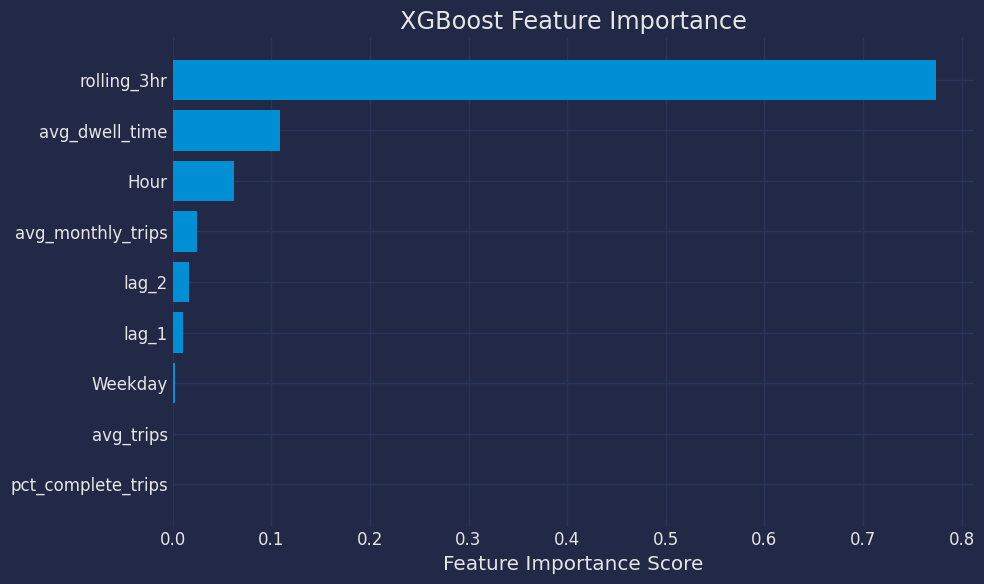

In [ ]:
# Plot feature importance
plt.figure(figsize=(10, 6))
xgb_importance = model.feature_importances_

# Match importances with feature names
feature_names = X.columns  # Same X used in training
sorted_idx = np.argsort(xgb_importance)

# Horizontal bar chart
plt.barh(range(len(sorted_idx)), xgb_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance Score")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

1. rolling_3hr — Most Important by Far
Explanation: This is the 3-hour rolling average of taxi arrivals.

Why it's important: It captures recent trends and smooths out hour-to-hour noise. XGBoost is clearly relying heavily on short-term historical behavior to predict the next hour.

Impact: ~80% of total importance — the model is very dependent on past few hours' flow.

2. avg_dwell_time
Explanation: How long taxis are staying at the airport.

Why it's important: A high dwell time might suggest congestion, affecting taxi inflow. If taxis are stuck inside longer, fewer might come in.

Impact: Moderate — model is using this to adjust expectations based on traffic buildup.

3. Hour
Explanation: Hour of the day (e.g., 9 AM vs 5 PM).

Why it's important: There are daily patterns — early mornings and evenings may be busier.

Impact: Helps detect time-of-day trends in demand.



<ipython-input-19-f3170e676036>:5: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/Taxi_2023-03-19.csv')
<ipython-input-19-f3170e676036>:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['Entry_Hour'] = df['Entry.time'].dt.floor('H') # Truncates time to the hour (e.g., 1:43 → 1:00)
<ipython-input-19-f3170e676036>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Entry_Hour'] = df['Entry.time'].dt.floor('H') # Truncates time to the hour (e.g., 1:43 → 1:00)
<ipython-input-19-f3170e676036>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

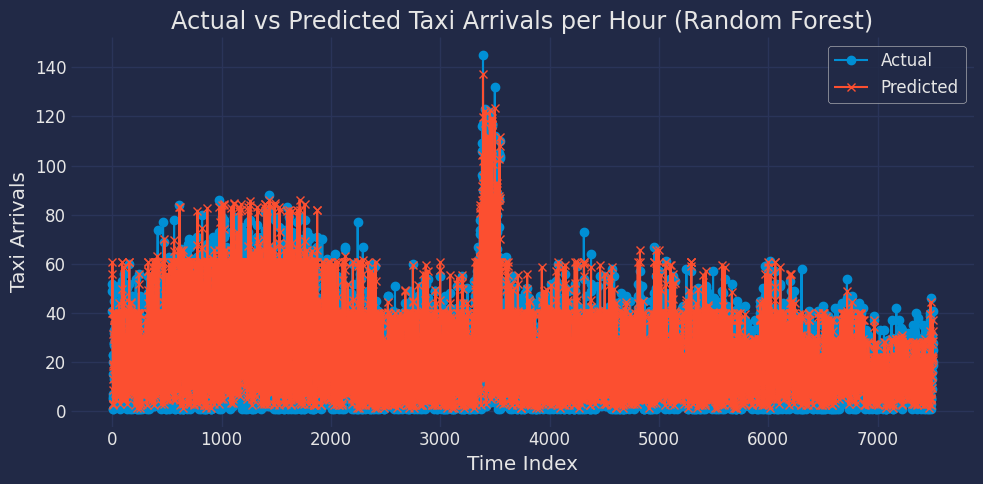

MAPE: 52.13%
Root Mean Squared Error (RMSE): 8.42


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Step 1: Load data

df = pd.read_csv('/content/Taxi_2023-03-19.csv')

# Step 2: Preprocess datetime and numeric fields
df['Entry.time'] = pd.to_datetime(df['Entry.time'], errors='coerce') # change format
df['Dwell.Time'] = pd.to_numeric(df['Dwell.Time'], errors='coerce')
df = df.dropna(subset=['Entry.time']) # drop missing value

# Step 3: Feature engineering
df['Entry_Hour'] = df['Entry.time'].dt.floor('H') # Truncates time to the hour (e.g., 1:43 → 1:00)
df['Hour'] = df['Entry_Hour'].dt.hour # The hour of the day (0–23)
df['Weekday'] = df['Entry_Hour'].dt.dayofweek #Day of the week (0=Monday)
df['Complete_trip_flag'] = df['Complete.trip'].map({'Yes': 1, 'No': 0}) # Converts "Yes"/"No" into 1/0 for analysis

# Step 4: Aggregate hourly features
hourly_features = df.groupby('Entry_Hour').agg(
    Taxi_Arrivals=('Entry_Hour', 'count'),
    avg_dwell_time=('Dwell.Time', 'mean'),
    pct_complete_trips=('Complete_trip_flag', 'mean'),
    avg_monthly_trips=('#TaxiMonthlyTrips', 'mean'),
    avg_trips=('#Trips', 'mean'),
    Hour=('Hour', 'first'),
    Weekday=('Weekday', 'first')
).reset_index()

# Step 5: Create lag and rolling features
hourly_features['lag_1'] = hourly_features['Taxi_Arrivals'].shift(1)
hourly_features['lag_2'] = hourly_features['Taxi_Arrivals'].shift(2)
hourly_features['rolling_3hr'] = hourly_features['Taxi_Arrivals'].rolling(3).mean()


# Step 6: Drop NA values caused by lag/rolling
hourly_features = hourly_features.dropna().reset_index(drop=True)

# Step 7: Define features and target
feature_cols = ['avg_dwell_time', 'pct_complete_trips', 'avg_monthly_trips',
                'avg_trips', 'Hour', 'Weekday', 'lag_1', 'lag_2', 'rolling_3hr']
X = hourly_features[feature_cols]
y = hourly_features['Taxi_Arrivals']

# Step 8: Time-based train/test split (80/20)
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Step 9: Train Random Forest model
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=6,
    random_state=42
)
model.fit(X_train, y_train)

#10 Model prediciton
y_pred = model.predict(X_test)


# Step 11: Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Taxi Arrivals per Hour (Random Forest)')
plt.xlabel('Time Index')
plt.ylabel('Taxi Arrivals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 12: Model Validation
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"MAPE: {mape:.2f}%")
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

In [ ]:
results_df = pd.DataFrame({
    'Entry_Hour': hourly_features['Entry_Hour'].iloc[split_index:].values,
    'Hour': hourly_features['Hour'].iloc[split_index:].values,  # Add Hour
    'Date': hourly_features['Entry_Hour'].dt.date.iloc[split_index:].values,  # Add Date
    'Actual_Taxi_Arrivals': y_test.values,
    'Predicted_Taxi_Arrivals': y_pred.round(2)  # Round for cleaner output
})

# Optional: Display first few rows
print(results_df.head(100))
print(results_df.sort_values('Actual_Taxi_Arrivals', ascending=False).head())


            Entry_Hour  Hour        Date  Actual_Taxi_Arrivals  \
0  2022-04-03 20:00:00    20  2022-04-03                    49   
1  2022-04-03 21:00:00    21  2022-04-03                    52   
2  2022-04-03 22:00:00    22  2022-04-03                    41   
3  2022-04-03 23:00:00    23  2022-04-03                    20   
4  2022-04-04 00:00:00     0  2022-04-04                    23   
..                 ...   ...         ...                   ...   
95 2022-04-08 05:00:00     5  2022-04-08                     2   
96 2022-04-08 06:00:00     6  2022-04-08                     3   
97 2022-04-08 07:00:00     7  2022-04-08                     5   
98 2022-04-08 08:00:00     8  2022-04-08                    22   
99 2022-04-08 09:00:00     9  2022-04-08                    17   

    Predicted_Taxi_Arrivals  
0                     39.95  
1                     56.04  
2                     60.80  
3                     39.95  
4                     31.45  
..                      ...

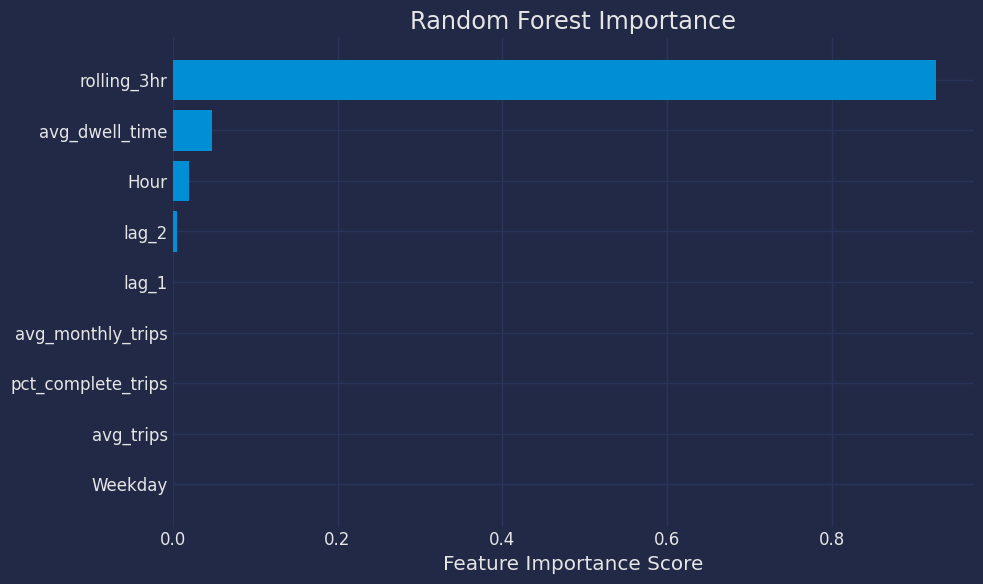

In [ ]:
# Assuming 'model' is your trained XGBoost model and 'X' is your feature DataFrame
random_importance = model.feature_importances_

# Match importances with feature names
feature_names = X.columns  # Same X used in training
sorted_idx = np.argsort(random_importance)

# Horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), random_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance Score")
plt.title("Random Forest Importance")
plt.tight_layout()
plt.show()


In [ ]:
'''
from google.colab import files

# Assuming 'results_df' is defined as in your provided code
# Replace 'results_df' with the actual DataFrame name if different

results_df.to_excel('results.xlsx', index=False)
files.download('results.xlsx')
hourly_features.to_excel('hourly_features.xlsx', index=False)
files.download('hourly_features.xlsx')
'''

"\nfrom google.colab import files\n\n# Assuming 'results_df' is defined as in your provided code\n# Replace 'results_df' with the actual DataFrame name if different\n\nresults_df.to_excel('results.xlsx', index=False)\nfiles.download('results.xlsx')\nhourly_features.to_excel('hourly_features.xlsx', index=False)\nfiles.download('hourly_features.xlsx')\n"

In [ ]:
# Assuming 'model' is your trained Random Forest model and 'X' is your feature DataFrame
y_pred_all = model.predict(X)

results_df_all = pd.DataFrame({
    'Entry_Hour': hourly_features['Entry_Hour'],
    'Hour': hourly_features['Hour'],
    'Date': hourly_features['Entry_Hour'],
    'Actual_Taxi_Arrivals': y,
    'Predicted_Taxi_Arrivals': y_pred_all.round(2)
})

# Display first few rows
print(results_df_all.head(100))

'''
from google.colab import files
results_df_all.to_excel('results.xlsx', index=False)
files.download('results.xlsx')
'''

            Entry_Hour  Hour                Date  Actual_Taxi_Arrivals  \
0  2018-01-01 02:00:00     2 2018-01-01 02:00:00                    38   
1  2018-01-01 03:00:00     3 2018-01-01 03:00:00                     9   
2  2018-01-01 04:00:00     4 2018-01-01 04:00:00                    15   
3  2018-01-01 05:00:00     5 2018-01-01 05:00:00                    25   
4  2018-01-01 06:00:00     6 2018-01-01 06:00:00                    21   
..                 ...   ...                 ...                   ...   
95 2018-01-06 09:00:00     9 2018-01-06 09:00:00                    59   
96 2018-01-06 10:00:00    10 2018-01-06 10:00:00                    66   
97 2018-01-06 14:00:00    14 2018-01-06 14:00:00                   182   
98 2018-01-06 16:00:00    16 2018-01-06 16:00:00                    83   
99 2018-01-06 17:00:00    17 2018-01-06 17:00:00                   135   

    Predicted_Taxi_Arrivals  
0                     83.81  
1                     18.57  
2                    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# prompt: find RSME for y_pred_all model

rmse_y_pred_all = np.sqrt(mean_squared_error(y, y_pred_all))
print(f"Root Mean Squared Error (RMSE) for y_pred_all: {rmse_y_pred_all:.2f}")
mape_y_pred_all = np.mean(np.abs((y - y_pred_all) / y)) * 100
print(f"MAPE for y_pred_all: {mape_y_pred_all:.2f}%")

Root Mean Squared Error (RMSE) for y_pred_all: 10.68
MAPE for y_pred_all: 40.69%
